# Benchmark for image dealiasing using a U-Net

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import matplotlib.pyplot as plt
import json, codecs
import numpy as np
from skimage import color
from keras.optimizers import Adam
from keras.datasets import cifar10

from fastmri_recon.helpers.utils import keras_ssim, keras_psnr
from fastmri_recon.data.test_generators import CifarGenerator
from fastmri_recon.models.unet import unet
from fastmri_recon.helpers.evaluate import psnr, ssim, mse, nmse

Using TensorFlow backend.


In [2]:
# parameter initialization
path = './gan/'
im_size = 32
AF=2
run_params = {
    'n_layers': 4, 
    'pool': 'max', 
    "layers_n_channels": [16, 32, 64, 128], 
    'layers_n_non_lins': 2,
}

In [3]:
def generator_model():
    model = unet(input_size=(im_size, im_size, 1), **run_params, compile=False)
    model.name = 'Reconstructor'
    return model

In [4]:
# define generator and load weights
g = generator_model()
g_opt = Adam(lr=1e-3, clipnorm=1.)
g.compile(optimizer=g_opt, loss='mse', metrics=[keras_psnr, keras_ssim])
g.load_weights(path + 'generator_benchmark.hdf5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [5]:
# load data
_, (x_test, _) = cifar10.load_data()
image_test = CifarGenerator(AF, im_size, color.rgb2gray(x_test), max_size=10000).flow_z_filled_images()

In [6]:
# evaluate generator
ev = g.evaluate_generator(image_test, steps=200, callbacks=None, verbose=1)
print('test loss, psnr,ssim:', ev)


/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/data/test_generators.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/helpers/reconstruction.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


200/200 [==============================] - 14s 70ms/step
test loss, psnr,ssim: [0.009619595482945442, 16.20930290222168, 0.5142915844917297]


In [7]:
def show_images(images, cols = 1, title=None, titles = None, scale = 1, save=''):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(facecolor="white")
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)) +1 , n + 1)
        plt.imshow(image, )
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images * scale)
    if save != '':
        plt.savefig(save)
    plt.show()

In [8]:
def show_prediction(g, im_true, im_alias):
    im_pred =  g.predict(im_alias)
    im_true = np.squeeze(im_true)
    im_alias = np.squeeze(im_alias)
    im_pred = np.squeeze(im_pred)
    show_images([im_true, im_alias, im_pred], titles=["true", "aliased", "predicted"])
    print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
    print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
    print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))
    

In [9]:
image_test = CifarGenerator(AF, im_size, color.rgb2gray(x_test), max_size=10000).flow_z_filled_images()

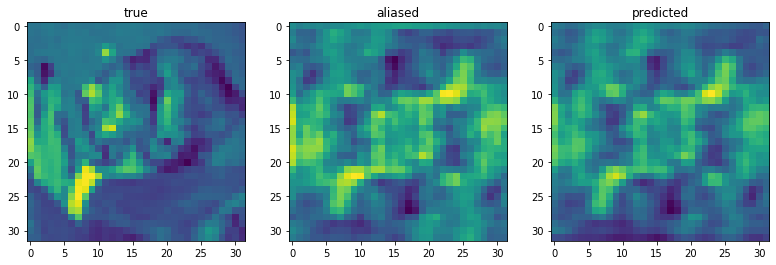

/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/helpers/evaluate.py:25: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


PSNR aliased image:  5.646172721554718 
PSNR predicted image: 16.905928908325553

MSE aliased image:  0.2067152414886762 
MSE predicted image: 0.015466672172959012

NMSE aliased image:  0.9927628131207122 
NMSE predicted image: 0.07427965574993055


In [10]:
im = next(image_test)
show_prediction(g, im[1], im[0])

In [11]:
# load training history
with open(path+'generator_training_history.json', 'r', encoding='utf-8') as file:
        history = json.loads(file.read())

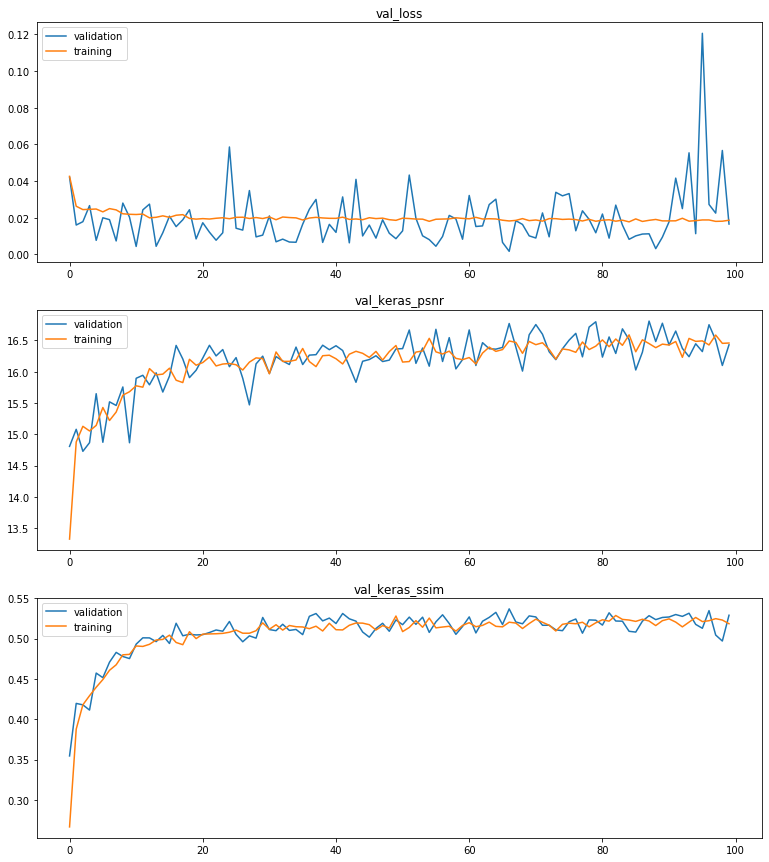

In [12]:
# plot training history
fig, _ = plt.subplots(2,2,figsize=(13,15))

images = [list(history[l].values()) for l in history]
titles = [l for l in history]

for i in range(len(titles)//2):
    plt.subplot(3, 1, i+1)
    plt.plot(images[i], label='validation')
    plt.plot(images[i+3], label='training')
    plt.title(titles[i])
    plt.legend()
plt.show()